In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset_test = pd.read_csv("fashion-mnist_test.csv")
dataset_train = pd.read_csv("fashion-mnist_train.csv")

In [ ]:
list_of_pixel_columns = list(dataset_test.columns)

In [ ]:
list_of_pixel_columns.remove('label')

In [ ]:
len_of_pixel = len(list_of_pixel_columns)

In [ ]:
def get_numpy_of_pixels(x):
  np_map = np.zeros(len_of_pixel)
  for i in range(1, len_of_pixel+1):
    np_map[i - 1] = x['pixel' + str(i)]
  return np_map

In [ ]:
test_pictures = dataset_test.apply(func = get_numpy_of_pixels , axis=1 )

In [ ]:
test_labels = dataset_test['label']

In [ ]:
test_labels.value_counts()

,count
label,
0,1000
1,1000
2,1000
3,1000
8,1000
6,1000
5,1000
4,1000
7,1000


In [ ]:
train_pictures = dataset_train.apply(func = get_numpy_of_pixels , axis=1 )
train_labels = dataset_train['label']

In [ ]:
sample = test_pictures[113].reshape(28,28)

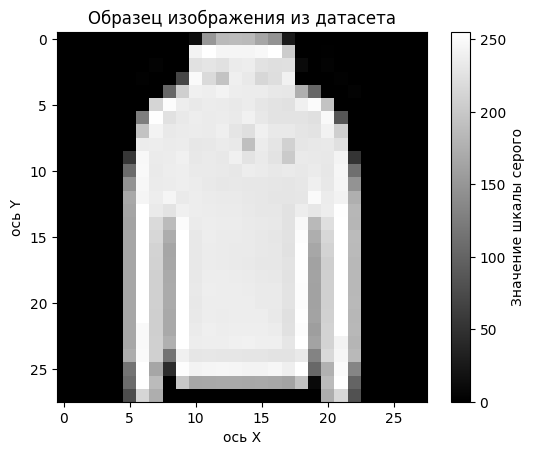

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Create a pixel map
plt.imshow(sample, cmap='gray', interpolation='nearest', aspect='equal')
plt.colorbar(label='Значение шкалы серого') # Add a colorbar to show the mapping
plt.title('Образец изображения из датасета')
plt.xlabel('ось X')
plt.ylabel('ось Y')
plt.show()

In [ ]:
test_pictures_numpy = np.vstack(test_pictures.values)
train_pictures_numpy = np.vstack(train_pictures.values)
train_labels_numpy =  np.vstack(train_labels.values)

In [ ]:
test_labels_numpy = np.vstack(test_labels.values)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
test_pictures_torch = torch.from_numpy(test_pictures_numpy).to(dtype=torch.float32).to(device)
train_pictures_torch = torch.from_numpy(train_pictures_numpy).to(dtype=torch.float32).to(device)
train_labels_torch = torch.from_numpy(train_labels_numpy).to(device)

In [ ]:
test_labels_torch = torch.from_numpy(test_labels_numpy).to(device)

In [ ]:
test_pictures_torch = test_pictures_torch.reshape(-1, 1, 28, 28)
train_pictures_torch = train_pictures_torch.reshape(-1, 1, 28, 28)

In [ ]:
train_pictures_torch.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
train_pictures_torch.dtype

torch.float32

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple feed-forward network
model = nn.Sequential(

       nn.Conv2d(1, 6, 5),
       nn.MaxPool2d(2, 2),
       nn.Conv2d(6, 8, 5),

       nn.Flatten(),

       nn.Linear( 512, 10),
       nn.LogSoftmax()
)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyCustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [ ]:
dataset = MyCustomDataset(train_pictures_torch, train_labels_torch)
batch_size = 32


In [ ]:
from torch.utils.data import random_split
train_len = int(0.8 * len(dataset) )
train_dataset, val_dataset = random_split(dataset, [train_len, len(dataset) - train_len ])


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=512, out_features=10, bias=True)
  (5): LogSoftmax(dim=None)
)

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
prev_val_loss = 1000000000

train_losses = []
val_losses = []

for epochs in range(0, 100):


  train_loss = 0

  for batch_data, batch_labels in train_dataloader:
    outputs = model(batch_data)

    #print(outputs.shape)

    loss = criterion(outputs, batch_labels.reshape(-1))

    train_loss +=  loss.detach().cpu().item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(train_dataset)

  train_losses.append(train_loss)

  print(train_loss)

  if epochs % 1 == 0:
    val_correct = 0
    val_loss = 0
    total = 0
    with torch.no_grad():
      for batch_data, batch_labels in val_dataloader:
        outputs = model(batch_data)

        loss = criterion(outputs, batch_labels.reshape(-1))

        predicted = torch.argmax(outputs, dim=1)
        val_correct += (predicted == batch_labels.reshape(-1)).sum().item()

        #print(predicted.shape)
        #print(batch_labels.shape)
        #print((predicted == batch_labels).sum())

        total += batch_labels.reshape(-1).shape[0]

        val_loss +=  loss.detach().cpu().item()

      print('correct = ', val_correct, 'total', total)

      val_loss = val_loss / len(val_dataset)


    val_losses.append(val_loss)

    if(val_loss > prev_val_loss ):
      break

    prev_val_loss = val_loss


0.03993191628778974
correct =  9811 total 12000
0.01570695408123235
correct =  10159 total 12000
0.013799781280569733
correct =  10127 total 12000


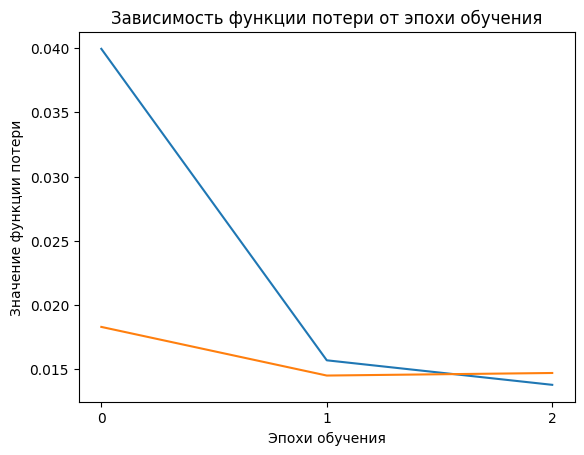

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(val_losses)), val_losses)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel('Значение функции потери')
plt.xlabel('Эпохи обучения')
plt.title('Зависимость функции потери от эпохи обучения')
plt.show()

In [ ]:
train_losses

[0.03993191628778974, 0.01570695408123235, 0.013799781280569733]

In [ ]:
val_losses

[0.018304471130793292, 0.014521460993215442, 0.014720512634143233]

In [ ]:
test_dataset = MyCustomDataset(test_pictures_torch, test_labels_torch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for batch_data, batch_labels in test_dataloader:
    outputs = model(batch_data)
    predicted = torch.argmax(outputs, dim=1)

    correct += (predicted == batch_labels.reshape(-1)).sum().item()

    total += batch_labels.reshape(-1).shape[0]

print('correct = ', correct, 'total', total)

correct =  8456 total 10000
